# 作为Reservoir Computing: Recurrent SNN的监督学习

**Reservoir Computing**为RNN模型之一。

通常的RNN模型对所有连接的权重进行学习，而Reservoir Computing对RNN单元间的连接权重进行随机初始化与固定。**仅学习输出的连接权重**。

于是，Reservoir Computing学习的参数很少，学习也能够高速地进行。

Reservoir 意为蓄水池。在水库计算中，输入信号首先通过随机固定权重转化为高阶空间中的信号，并存储在水库 RNN（信号水库）中。然后，存储为水库 RNN 单元活动的信息通过可训练权重进行线性变换，从而产生输出。输出权重不断更新，使网络输出与教师信号相匹配。

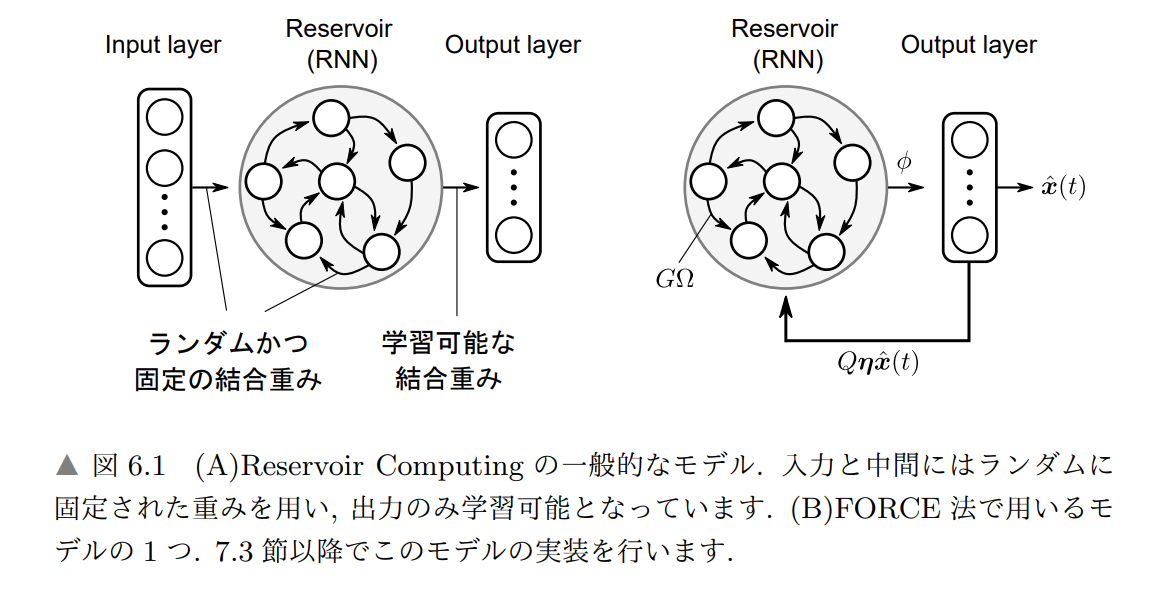

## 6.2 FORCE 法与向Recurrent SNN的应用

水库计算中的一种监督学习方法称为 FORCE 方法。FORCE（一阶减小和控制误差）方法由（Sussillo & Abbott, 2009）提出，最初是一种基于发射率的 RNN 的在线学习方法（具体方法将在下一节中解释）。

此外，（Nicola & Clopath, 2017）的研究表明，FORCE 方法可以直接用于学习循环 SNN，因为它是一种可以用于学习循环 SNN 的方法。本章将使用 Nicola 等人的方法对作为水库计算的递归 SNN 进行监督学习。

## 6.3 使用Recurrent SNN学习正弦波

我们的目标是将 Recurrent SNN 中神经元的解码活动训练成正弦信号（即使用正弦信号作为教师信号）。结果使用图进行表示。

### 6.3.1 网路结构与学习信号

网络结构如图所示。该网络没有任何特殊的输入，而是通过递归输入来维持（由于膜电位的初始值是随机的，因此有一些神经元 会在开始时发射，而且还有一个偏置电流）。首先，让$N$表示储层神经元的数量，$N_{out}$ 表示输出的数量。第 $i$ 个神经元的输入偏置电流为 $I_{Bias}$

$$I_i = s_i + I_{Bias}$$

其中$s_i = \sum_{j=1}^N w_{ij}r_j$

$r_j$为j-th 神经元的输出（附加了突触滤波器的尖峰列）。

$w_{ij}$为神经元i, j的连接权重。

接下来令$\phi \in \mathbb R^{N\times N_{out}}$对神经元活动$r_j$进行线性编码，之后令输出$\hat x(t) = \sum_{j=1}^N \phi_jr_j=\phi^T\bold r$

$r_j \in \mathbb R^{N_{out}}$

$\Omega = [w_{ij}]\in \mathbb R^{N\times N}$

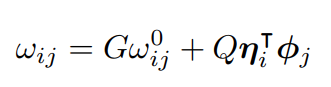

其中$G, Q$为常数，$\eta = [\bold \eta_i^T]\mathbb R^{N\times N_{out}}$为由概率决定的-1或1矩阵。

$w_{ij}^0$为被固定了的递归权重。于是仅有$\phi$需要被学习

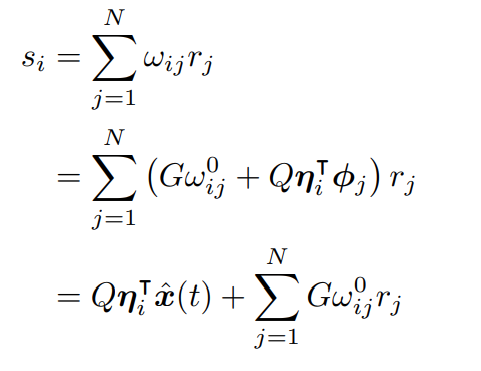

### 6.3.2 固定权重初始化


固定的连接权重 $ω^0_{ij}$ 从 $\mathcal N(0,(Np)^{-1} )$ 的正态分布中随机取样，其中 N为神经元数量，p为常数。

每个神经元都会按比例调整，使投影权重的平均值为零。

### 6.3.3 基于RLS法的权重更新

FORCE 方法将一种名为 **RLS 滤波器（递归最小二乘滤波器）**的**自适应滤波器**学习算法应用于 RNN 训练。FORCE 方法是一种将误差设定为

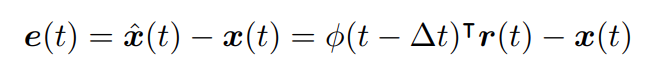

该设定下，输出权重如下更新:

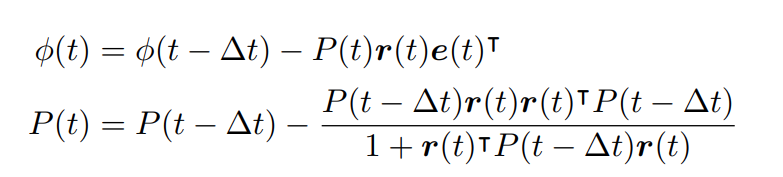

此外，这些式子的初始值$\phi(0)=0, P(0)=I_N\lambda^{-1}$

$I_N$为$N$次单位矩阵。$\lambda$为为了正则化使用的常数。

### 6.3.4 FORCE 法的实现

现在让我们执行 FORCE 方法*5。假设水库网络由 2000 个 LIF 神经元组成。输出单元数为 1。首先，我们定义各种常数和教师信号

In [1]:
import numpy as np
N = 2000 # ニューロンの数
dt = 5e-5 # タイムステップ (s)
tref = 2e-3 # 不応期 (s)
tc_m = 1e-2 #　膜時定数 (s)
vreset = -65 # リセット電位 (mV)
vrest = 0 # 静止膜電位 (mV)
vthr = -40 # 閾値電位 (mV)
vpeak = 30 # ピーク電位 (mV)
BIAS = -40 # 入力電流のバイアス (pA)
td = 2e-2; tr = 2e-3 # シナプスの時定数 (s)
alpha = dt*0.1
P = np.eye(N)*alpha
Q = 10; G = 0.04
T = 15 # シミュレーション時間 (s)
tmin = round(5/dt) # 重み更新の開始ステップ
tcrit = round(10/dt) # 重み更新の終了ステップ
step = 50 # 重み更新のステップ間隔
nt = round(T/dt) # シミュレーションステップ数
zx = np.sin(2*np.pi*np.arange(nt)*dt*5) # 教師信号

In [2]:
from Models.Neurons import CurrentBasedLIF
from Models.Synapses import DoubleExponentialSynapse
# ニューロンとシナプスの定義
neurons = CurrentBasedLIF(N=N, dt=dt, tref=tref, tc_m=tc_m,
vrest=vrest, vreset=vreset, vthr=vthr, vpeak=vpeak)
neurons.v = vreset + np.random.rand(N)*(vpeak-vreset) # 膜電位の初期化
synapses_out = DoubleExponentialSynapse(N, dt=dt, td=td, tr=tr)
synapses_rec = DoubleExponentialSynapse(N, dt=dt, td=td, tr=tr)
# 再帰重みの初期値
p = 0.1 # ネットワークのスパース性
OMEGA = G*(np.random.randn(N,N))*(np.random.rand(N,N)<p)/(np.sqrt(N)*p)
for i in range(N):
    QS = np.where(np.abs(OMEGA[i,:])>0)[0]
    OMEGA[i,QS] = OMEGA[i,QS] - np.sum(OMEGA[i,QS], axis=0)/len(QS)

ModuleNotFoundError: No module named 'Models'

In [4]:
# 変数の初期値
k = 1 # 出力ニューロンの数
E = (2*np.random.rand(N, k) - 1)*Q
PSC = np.zeros(N).astype(np.float32) # シナプス後電流
JD = np.zeros(N).astype(np.float32) # 再帰入力の重み和
z = np.zeros(k).astype(np.float32) # 出力の初期化
Phi = np.zeros(N).astype(np.float32) #　学習される重みの初期値

# 記録用変数
REC_v = np.zeros((nt,10)).astype(np.float32) # 膜電位の記録変数
current = np.zeros(nt).astype(np.float32) # 出力の電流の記録変数
tspike = np.zeros((4*nt,2)).astype(np.float32) # スパイク時刻の記録変数
ns = 0 # スパイク数の記録変数

In [8]:
from tqdm import tqdm
for t in tqdm(range(nt)):
    # get post-synapse current, feeding into neurons.
    I = PSC + np.dot(E, z) + BIAS # シナプス電流
    s = neurons(I) # 中間ニューロンのスパイク
    
    index = np.where(s)[0] # 発火したニューロンの index
    len_idx = len(index) # 発火したニューロンの数
    if len_idx > 0:
        JD = np.sum(OMEGA[:, index], axis=1)
        tspike[ns:ns+len_idx,:] = np.vstack((index, 0*index+dt*t)).T
        ns = ns + len_idx # スパイク数の記録
    PSC = synapses_rec(JD*(len_idx>0)) # 再帰的入力電流
    #PSC = np.dot(OMEGA, r) # 遅い
    r = synapses_out(s) # 出力電流 (神経伝達物質の放出量)
    r = np.expand_dims(r,1) # (N,) -> (N, 1)
    z = np.dot(Phi.T, r) # デコードされた出力
    err = z - zx[t] # 誤差
    
    # FORCE 法 (RLS) による重み更新
    if t % step == 1:
        if t > tmin:
            if t < tcrit:
                cd = np.dot(P, r)
                Phi = Phi - np.dot(cd, err.T)
                P = P - np.dot(cd, cd.T) / (1.0 + np.dot(r.T, cd))
    current[t] = z # デコード結果の記録
    REC_v[t] = neurons.v_[:10] # 膜電位の記録

  0%|          | 0/300000 [00:00<?, ?it/s]

100%|██████████| 300000/300000 [04:19<00:00, 1157.92it/s]


一路上我们做了一些奇怪的事情。`PSC = synapses_rec(JD*(len_idx>0))`（以及上面一部分）。
因为将发射关节权重相加并输入递归输入突触后细胞模型比矩阵变换 r 进行解码更快。

若 t 在恒定步长范围内，则使用 FORCE 方法进行训练。最后，记录各种变量。现在我们来展示训练后的结果。首先显示的是击发次数和击发率，然后是学习前后五个神经元的膜电位，最后是学习前/中和学习后的解码结果（注意，代码中还包括权重特征值图，本书未包含）。



Total number of spikes :  635905
Average firing rate(Hz):  22.5191


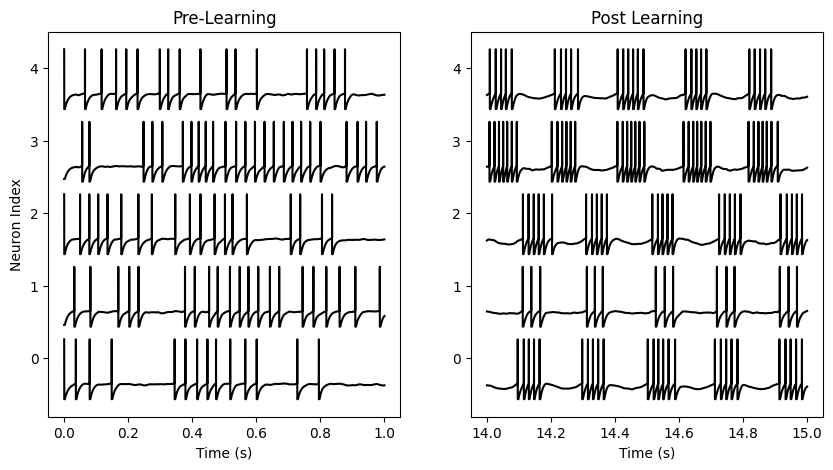

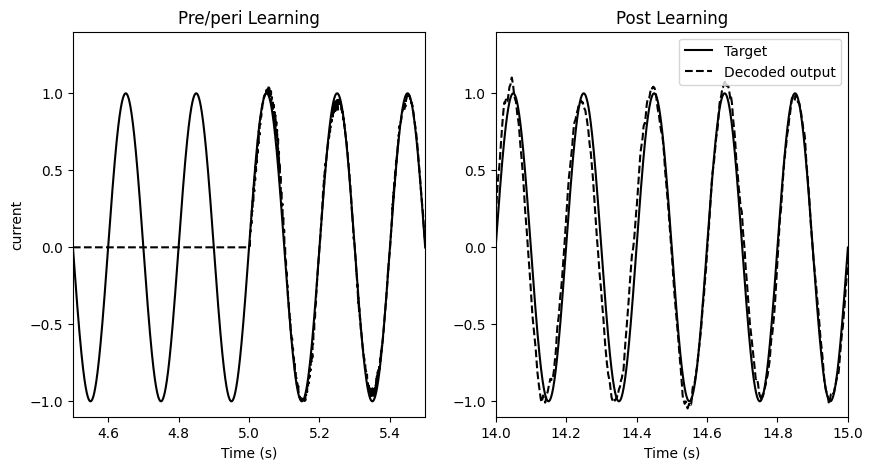

In [11]:
import numpy as np
import matplotlib.pyplot as plt
TotNumSpikes = ns
M = tspike[tspike[:,1]>dt*tcrit,:]
AverageRate = len(M)/(N*(T-dt*tcrit))
print("\n")
print("Total number of spikes : ", TotNumSpikes)
print("Average firing rate(Hz): ", AverageRate)
step_range = 20000
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
for j in range(5):
    plt.plot(np.arange(step_range)*dt,
    REC_v[:step_range, j]/(50-vreset)+j, color="k")
plt.title('Pre-Learning')
plt.xlabel('Time (s)'); plt.ylabel('Neuron Index')
plt.subplot(1,2,2)
for j in range(5):
    plt.plot(np.arange(nt-step_range, nt)*dt,
    REC_v[nt-step_range:, j]/(50-vreset)+j,
    color="k")
plt.title('Post Learning'); plt.xlabel('Time (s)')
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(np.arange(nt)*dt, zx, label="Target", color="k")
plt.plot(np.arange(nt)*dt, current, label="Decoded output",
linestyle="dashed", color="k")

plt.xlim(4.5,5.5); plt.ylim(-1.1,1.4)
plt.title('Pre/peri Learning')
plt.xlabel('Time (s)'); plt.ylabel('current')
plt.subplot(1,2,2)
plt.title('Post Learning')
plt.plot(np.arange(nt)*dt, zx, label="Target", color="k")
plt.plot(np.arange(nt)*dt, current, label="Decoded output",
linestyle="dashed", color="k")
plt.xlim(14,15); plt.ylim(-1.1,1.4)
plt.xlabel('Time (s)'); plt.legend(loc='upper right')
plt.show()


### 6.3.5 鸟鸣声的再现以及海马记忆的再现

尼古拉等人使用范德尔波尔方程和洛伦兹方程的轨迹以及正弦波作为教师信号进行了实验。此外，使用贝多芬的《欢乐颂》或鸟鸣作为教师信号似乎也可以进行学习。离题了，但鸟类的前运动皮层 HVC 包含一连串相互连接的神经元。据说这些神经元参与计时以产生节奏*7。与此类似，消减SNN中的HVC模式似乎也能阻止学过的歌曲再现。尼古拉等人将这种时间模式称为 HDTS（高分辨率时间信号）。当在 HDTS 训练后学习欢快的歌曲时，似乎比没有 HDTS 时学习时间更短，准确率更高。我们还进行了将 HDTS 作为外部输入同时学习视频的实验（我们还进行了 HDTS 内部学习的实验）。网络能够实时播放录制的视频，但通过加速外部 HDTS 信号，可以实现压缩播放。此外，通过反转 HDTS，网络还能反向播放视频。实验中已经观察到神经元发射的任务依赖性压缩（如 Euston 等人，2007 年）。当给大鼠布置一项空间任务（如在一个盒子中搜索）时，任务期间储存的位置细胞的有序活动会被压缩，并在大鼠睡眠期间重放。压缩比为 5.4 到 8.1，几乎与 SNNs 能够重现图像而无明显损失的压缩比相同。尼古拉等人更进一步，利用SNNs研究了海马快速压缩学习*8机制中中间神经元的功能（Nicola & Clopath, 2019）。

## 6.4 RLS 法導出

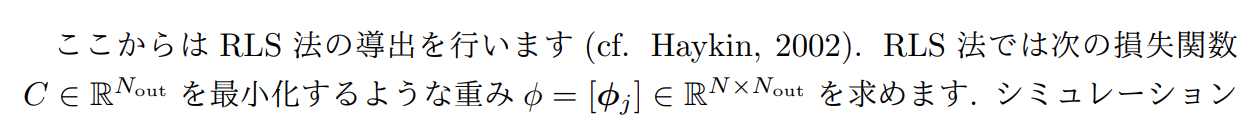

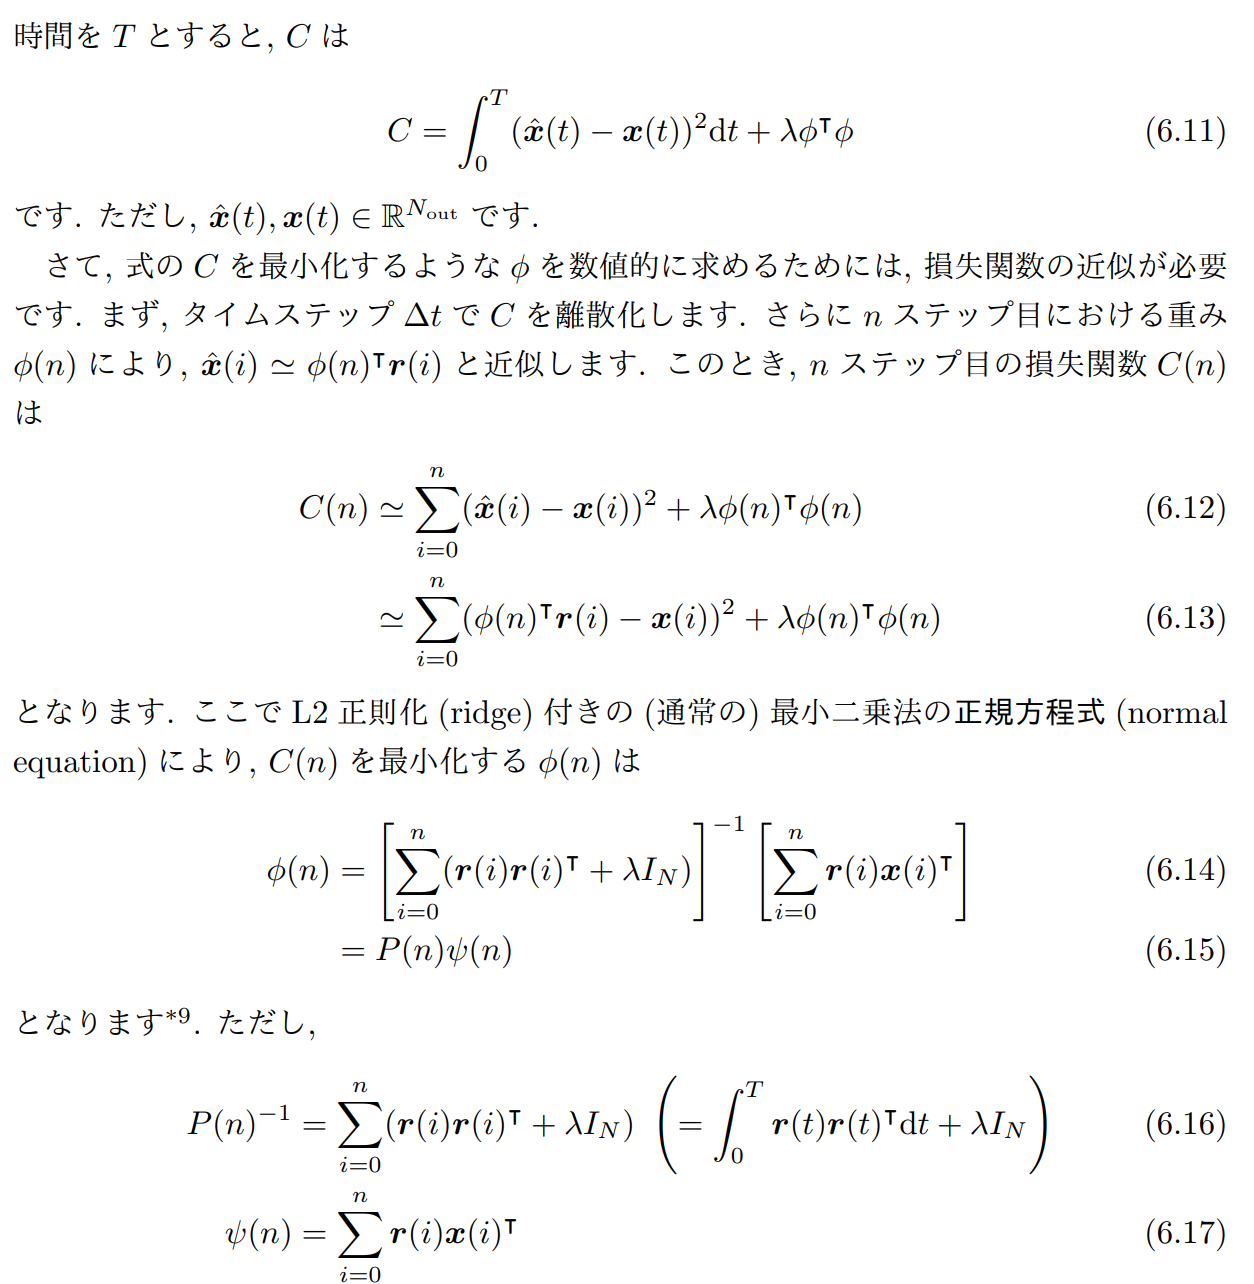

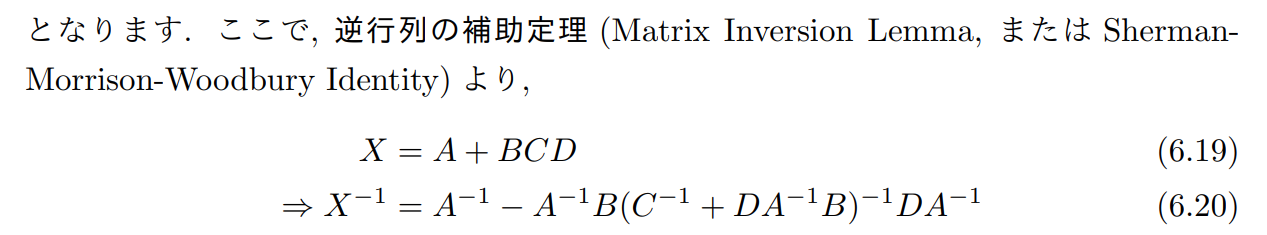

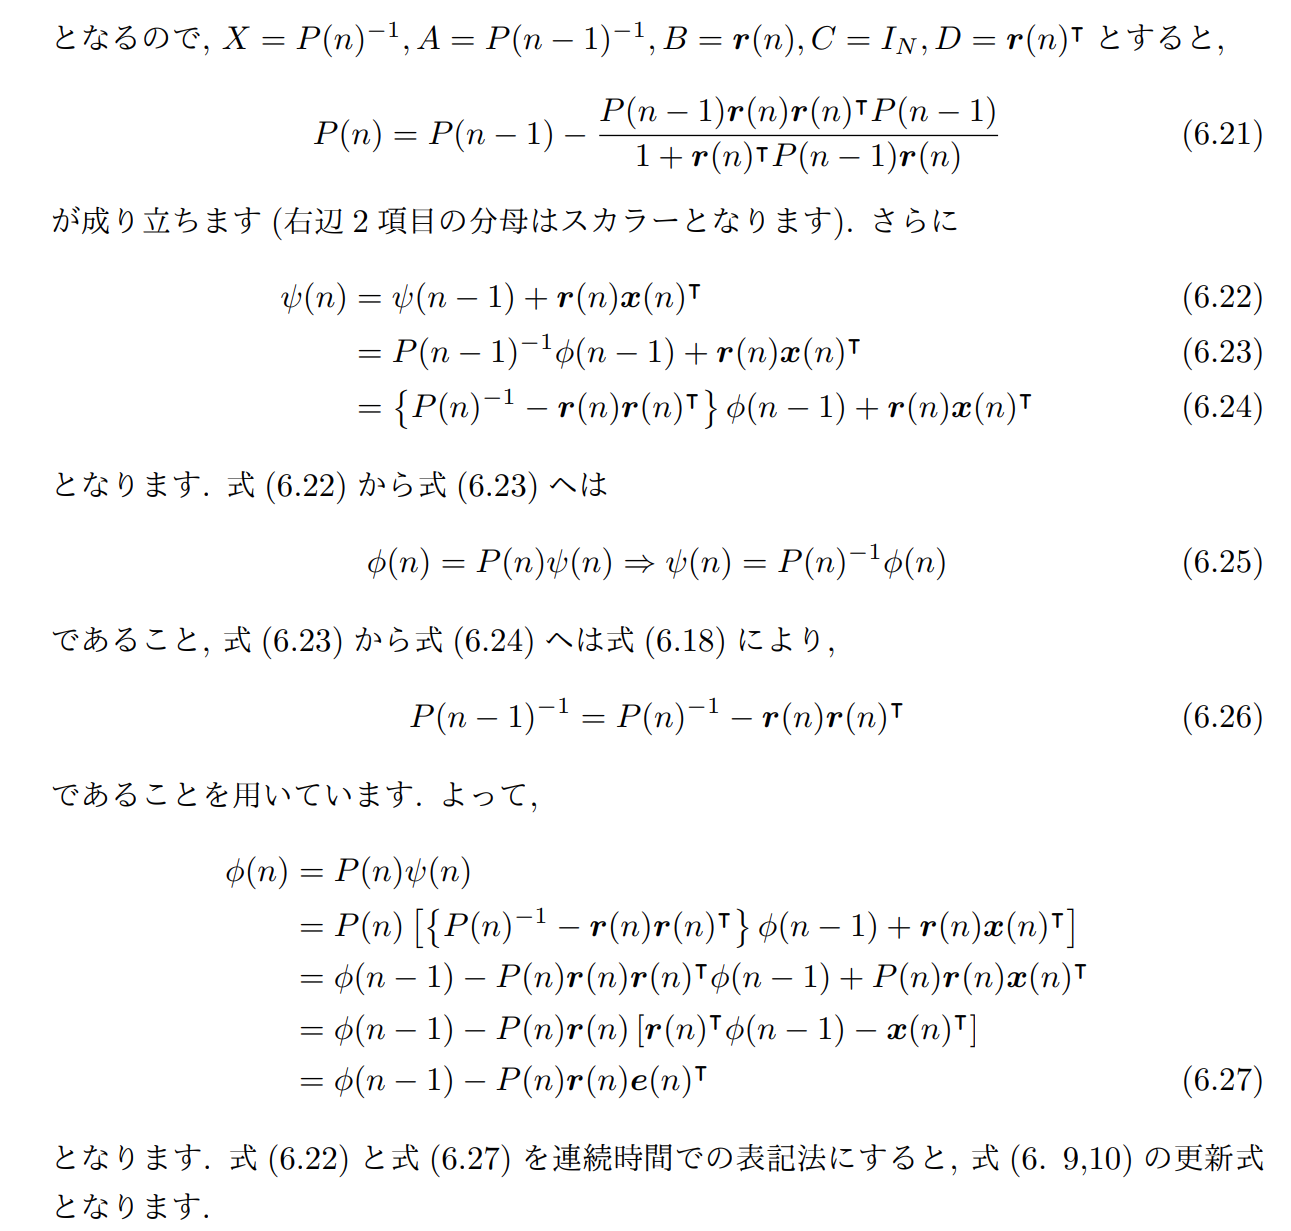

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def draw_random_normal_int(low:int, high:int):

    # generate a random normal number (float)
    normal = np.random.normal(loc=0, scale=1, size=1)

    # clip to -3, 3 (where the bell with mean 0 and std 1 is very close to zero
    normal = -3 if normal < -3 else normal
    normal = 3 if normal > 3 else normal

    # scale range of 6 (-3..3) to range of low-high
    scaling_factor = (high-low) / 6
    normal_scaled = normal * scaling_factor

    # center around mean of range of low high
    normal_scaled += low + (high-low)/2

    # then round and return
    return np.round(normal_scaled)

In [15]:
samples = [int(draw_random_normal_int(0, 256)) for _ in range(100000)]

C:\Users\Micro\AppData\Local\Temp\ipykernel_4176\3756697805.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  samples = [int(draw_random_normal_int(0, 256)) for _ in range(100000)]


(array([  825.,  2840.,  7733., 16057., 22141., 22832., 16189.,  7810.,
         2764.,   809.]),
 array([  0. ,  25.6,  51.2,  76.8, 102.4, 128. , 153.6, 179.2, 204.8,
        230.4, 256. ]),
 <BarContainer object of 10 artists>)

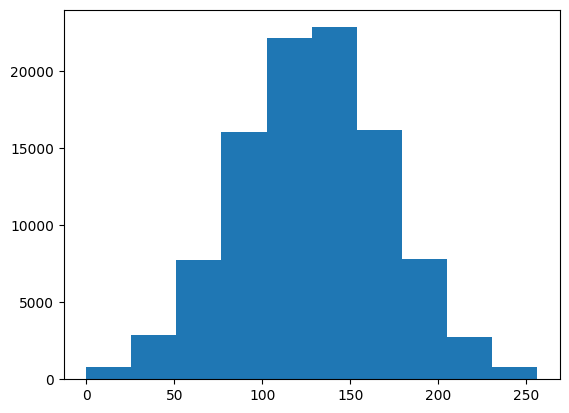

In [16]:
plt.hist(samples)